<a href="https://colab.research.google.com/github/McGirk/laguardia-classwork/blob/main/PredictiveCapstone_DirkdePagterAllison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project Intro: Looking at IMDb data to predict good-quality low-budget hits

**This project aims to predict factors contributing to the success of low-budget movies, focusing on profitability and quality metrics.**

I found a dataset that seems to have already combined features I was interested in regarding movies that included budget, box office, and rating.
Starting here: https://www.kaggle.com/datasets/austinwolff/comprehensive-imdb-data

This data set detail card includes the following statement:

> This dataset is a merging of imdb.com's public relational datasets, and filtered to include movies released in the United States between 1980-2020, and excludes movies that don't have data on its gross revenue (box office). This dataset might be good for anyone trying to analyze what factors contribute to a movie's box office.

Sounds like it's right up my alley, but we need to take a closer look.

We're going to start with downloading the data set from Kaggle and then put it into a dataframe to explore a little.

In [ ]:
# This code segment is helpfully provided by Kaggle when downloading a data set

import kagglehub

# Download latest version
path = kagglehub.dataset_download("austinwolff/comprehensive-imdb-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/austinwolff/comprehensive-imdb-data/versions/1


In [ ]:
!ls {path} # see what our file name actually is

'Comprehensive IMDb Data.csv'


In [ ]:
import pandas as pd

file_path = f"{path}/Comprehensive IMDb Data.csv"
df_IMDBfull = pd.read_csv(file_path)
print(df_IMDBfull.shape)
print(df_IMDBfull.head())
print(df_IMDBfull.info())

(222569, 22)
     titleId        title rating region  genre    released  year month   day  \
0  tt0081505  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
1  tt0118460  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
2  tt0118460  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
3  tt0118460  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
4  tt0118460  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   

   score  ...            star         country      budget       gross  \
0    8.4  ...  Jack Nicholson  United Kingdom  19000000.0  46998772.0   
1    8.4  ...  Jack Nicholson  United Kingdom  19000000.0  46998772.0   
2    8.4  ...  Jack Nicholson  United Kingdom  19000000.0  46998772.0   
3    8.4  ...  Jack Nicholson  United Kingdom  19000000.0  46998772.0   
4    8.4  ...  Jack Nicholson  United Kingdom  19000000.0  46998772.0   

        company  runtime category     nconst         primaryName  \

# Initial Assessments and Thoughts

Looks like we have a data set that includes several features that feel potentially determinative of a quality low-budget hit. The person who prepared this data set mentioned that **box office gross** was the feature they wanted to make sure was complete.

It looks like we have some missing values for date, month, and day of release. It looks like we always have a release year, but we'll confirm that in a bit.

*   Missing values in date, month, and day could affect time-based analyses (e.g., release season effects on success).
*   We could check if missing dates are disproportionately associated with certain decades or countries.
*   We might consider imputing these with common defaults if the year is known (e.g., assign July 1 for missing dates).

Features we'll want to think about for cleaning and wrangling include
*   rating
*   writer
*   country
*   budget
*   runtime

I see that the **budget** feature has null values for about 60k lines, and that's a critical feature to include for determining lower-budget successes. So, I may want to think about what the entries with no budget values look like.
*   Are missing budgets more common in certain years, genres, or countries?
*   Is there a relationship between missing budgets and other variables (e.g., null values in runtime or box office gross)?

I see that we have a line for every unique **primaryName** value for each film. As we start to think about encoding, I'm thinking director, writer, and star are each important. But I'm also thinking that maybe the number of other titles a primary is known for could be a helpful valence, as well as maybe a way to get an average score for the other titles a primary is known for.
*   **Number of Appearances in Data Set**: A proxy for experience or notoriety.
*   **Average Rating of Other Titles**: Could indicate quality consistency.
*   **Genre-Specific Success**: Are these contributors known for successes in particular genres?

Some features (e.g., writer, country, rating) will need to be encoded for modeling. We might consider, for example:
*   **Rating**: Encode as ordinal (e.g., G < PG < PG-13 < R < NC-17 < Not Rated).
*   **Country**: Group low-frequency countries into an "Other" category or encode top countries with dummy variables.
*   **Writer/Director**: Use one-hot encoding or assign a numeric identifier for high-frequency contributors.

Since budget is critical, we might want to explore:
*   Whether films with missing budget values tend to have low or zero box office grosses (indicating non-theatrical releases).
*   If there's a way to estimate missing budgets using similar films (e.g., same year, genre, runtime).

Embarking on our EDA, let's first check the unique values for the following features:

 *   rating          (221171 non-null  object)
 *   region          (222569 non-null  object)
 *   genre           (222569 non-null  object)
 *   country         (222552 non-null  object)
 *   company         (222225 non-null  object)
 *   category        (222569 non-null  object)

# Importing Libraries for EDA


In [ ]:
# we already imported pandas in a previous cell
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


unique values check

In [ ]:
# List of features to check
features_to_check = ['rating', 'region', 'genre', 'country', 'company', 'category']

# Loop through each feature and print unique values
for feature in features_to_check:
    print(f"Unique values for {feature}:")
    print(df_IMDBfull[feature].unique())
    print("\n")
# Count unique values for each feature
for feature in features_to_check:
    print(f"Number of unique values for {feature}: {df_IMDBfull[feature].nunique()}")


Unique values for rating:
['R' 'PG' 'PG-13' 'G' 'Not Rated' 'NC-17' nan 'Approved' 'Unrated' 'X'
 'TV-PG' 'TV-MA' 'TV-14']


Unique values for region:
['US']


Unique values for genre:
['Drama' 'Adventure' 'Action' 'Comedy' 'Horror' 'Biography' 'Crime'
 'Fantasy' 'Family' 'Animation' 'Romance' 'Music' 'Western' 'Thriller'
 'Sci-Fi' 'Mystery' 'Sport' 'Musical']


Unique values for country:
['United Kingdom' 'United States' 'South Africa' 'West Germany' 'Canada'
 'France' 'Australia' 'Italy' 'China' 'South Korea' 'Sweden' 'Spain'
 'Hong Kong' 'Mexico' 'Switzerland' 'Netherlands' 'Germany' 'Philippines'
 'Japan' 'Czech Republic' 'Brazil' 'New Zealand' 'Yugoslavia' 'Thailand'
 'Argentina' 'Israel' 'Denmark' 'Ireland' 'Russia' 'Belgium' 'Austria'
 'Portugal' 'Vietnam' 'Taiwan' 'Federal Republic of Yugoslavia' 'Iran'
 'Norway' 'Jamaica' 'Aruba' 'Hungary' 'India' 'Colombia' 'Romania'
 'Greece' 'United Arab Emirates' 'Indonesia' 'Turkey' 'Serbia' 'Poland'
 'Kenya' 'Finland' 'Iceland' 'Chile' '

OK, this helps with what the cleaning and encoding strategies might be when we get there.

But let's dig into the titles that are missing budget information.

In [ ]:
# we'll actually start by exploring projects with missing budget info
df_missing_budget = df_IMDBfull[df_IMDBfull['budget'].isna()]
unique_titles_missing_budget = df_missing_budget[['titleId','title', 'genre', 'year']].drop_duplicates()
print(unique_titles_missing_budget.head(20))  # Display first 20 rows
print(unique_titles_missing_budget.tail(20))  # Display last 20 rows




        titleId         title   genre  year
336   tt0080716          Fame   Drama  1980
337   tt0860058          Fame   Drama  1980
339   tt0083412          Fame   Drama  1980
341   tt0368494          Fame   Drama  1980
342  tt10447488          Fame   Drama  1980
343   tt2385203          Fame   Drama  1980
344   tt1016075          Fame   Drama  1980
347   tt1314740          Fame   Drama  1980
348   tt0325350          Fame   Drama  1980
350   tt5864096          Fame   Drama  1980
351  tt12280924          Fame   Drama  1980
367   tt6802316          Fame   Drama  1980
618   tt4789924    Stir Crazy  Comedy  1980
619   tt0088617    Stir Crazy  Comedy  1980
620  tt12269536    Stir Crazy  Comedy  1980
627   tt0081562    Stir Crazy  Comedy  1980
632   tt6705160    Stir Crazy  Comedy  1980
633   tt2118728    Stir Crazy  Comedy  1980
745   tt0081696  Urban Cowboy   Drama  1980
746   tt4955762  Urban Cowboy   Drama  1980
           titleId             title  genre  year
222388   tt0028203  Romeo 

# An Unfortunate Discovery

Well, shoot. It looks like our data set is faulty. I'm seeing multiple `titleId` values for the same title with the same genre and year. When I do some spot checking on IMDb, I see that the title matches but that some `titleId`s actually correspond to tv episode titles, tv series, or movie remake titles and all the rest of the features have been overwritten with the values from the movie. This will alter my strategy for dealing with this data set considerably.

I'm going to start by identifying my suspicious duplicates.

In [ ]:
# Group by title and count unique titleId values
title_counts = df_IMDBfull.groupby('title')['titleId'].nunique().reset_index()

# Rename the columns for clarity
title_counts.columns = ['title', 'unique_titleId_count']

# Filter for titles with more than one unique titleId
suspicious_titles = title_counts[title_counts['unique_titleId_count'] > 1]

# Display the suspicious titles
print(suspicious_titles)


                           title  unique_titleId_count
1                'Round Midnight                     2
5     10 Things I Hate About You                     3
6                       10 Years                     2
9                 101 Dalmatians                     2
11                    12 Monkeys                     2
...                          ...                   ...
7091                      Zodiac                     3
7093                  Zombieland                     2
7098                        Zoom                     8
7099                   Zoot Suit                     2
7106                    Æon Flux                     3

[3570 rows x 2 columns]


In [ ]:
# Filter the original DataFrame for suspicious titles
suspicious_title_details = df_IMDBfull[df_IMDBfull['title'].isin(suspicious_titles['title'])]

# Display relevant columns for inspection
print(suspicious_title_details[['title', 'titleId', 'genre', 'year']].sort_values(by='title'))


                  title    titleId   genre  year
31041   'Round Midnight  tt0090557   Drama  1986
31043   'Round Midnight  tt0090557   Drama  1986
31044   'Round Midnight  tt0090557   Drama  1986
31042   'Round Midnight  tt0455296   Drama  1986
31045   'Round Midnight  tt0455296   Drama  1986
...                 ...        ...     ...   ...
138914         Æon Flux  tt0795512  Action  2005
138915         Æon Flux  tt0111873  Action  2005
138916         Æon Flux  tt0402022  Action  2005
138903         Æon Flux  tt0402022  Action  2005
138893         Æon Flux  tt0795512  Action  2005

[191487 rows x 4 columns]


# Triage Cleaning

Right, this confirms that we have `genre` and `year` information repeated for unique `titleId`s with the same `title` value. So, I'm going to try to identify the actual movie by matching to the `title.basics.tsv` file from the IMDb data files, matching to year and title.

In the real world, I would take this opportunity to discuss the issues with the data set with my team, but for this project I will proceed, acknowledging the limitations and assumptions made in this approach.

In [ ]:
imdb_titles = pd.read_csv('title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'primaryTitle', 'startYear'])
imdb_titles.rename(columns={'tconst': 'titleId', 'startYear': 'year'}, inplace=True)
imdb_movies = imdb_titles[imdb_titles['titleType'] == 'movie']

df_IMDBfull['year'] = pd.to_numeric(df_IMDBfull['year'], errors='coerce')
imdb_movies['year'] = pd.to_numeric(imdb_movies['year'], errors='coerce')


# Merge with original dataset
df_merged = df_IMDBfull.merge(imdb_movies, on=['titleId', 'year'], how='inner')

duplicate_title_ids = df_merged[df_merged.duplicated(subset=['titleId'], keep=False)]
print(duplicate_title_ids[['titleId', 'title', 'year', 'titleType']].head())

print(df_merged.shape)
print(df_merged.head())
print(df_merged.info())

<ipython-input-58-53c73e5efdfb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_movies['year'] = pd.to_numeric(imdb_movies['year'], errors='coerce')


     titleId        title  year titleType
0  tt0081505  The Shining  1980     movie
1  tt0081505  The Shining  1980     movie
2  tt0081505  The Shining  1980     movie
3  tt0081505  The Shining  1980     movie
4  tt0081505  The Shining  1980     movie
(63161, 24)
     titleId        title rating region  genre    released  year month   day  \
0  tt0081505  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
1  tt0081505  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
2  tt0081505  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
3  tt0081505  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   
4  tt0081505  The Shining      R     US  Drama  1980-06-13  1980  June  13.0   

   score  ...      budget       gross       company runtime  category  \
0    8.4  ...  19000000.0  46998772.0  Warner Bros.   146.0     actor   
1    8.4  ...  19000000.0  46998772.0  Warner Bros.   146.0     actor   
2    8.4  ...  19000000.0  46998772.

checking merge results

In [ ]:
print(df_merged[['titleId', 'title', 'year', 'budget', 'gross', 'titleType']].groupby('titleId').head(1).head(25))


       titleId                                           title  year  \
0    tt0081505                                     The Shining  1980   
7    tt0080453                                 The Blue Lagoon  1980   
15   tt0080684  Star Wars: Episode V - The Empire Strikes Back  1980   
25   tt0080339                                       Airplane!  1980   
35   tt0080487                                      Caddyshack  1980   
43   tt0080761                                 Friday the 13th  1980   
51   tt0758746                                 Friday the 13th  2009   
61   tt0080455                              The Blues Brothers  1980   
69   tt0081398                                     Raging Bull  1980   
79   tt0081573                                     Superman II  1980   
89   tt0081071                                 The Long Riders  1980   
98   tt0080377                           Any Which Way You Can  1980   
107  tt0080801                          The Gods Must Be Crazy  

In [ ]:
unique_title_count = df_merged['titleId'].nunique()
print(f"Total unique movies after merging: {unique_title_count}")


Total unique movies after merging: 7190


unique feature values check again on matched data frame

In [ ]:
# List of features to check
features_to_check = ['rating', 'region', 'genre', 'country', 'company', 'category']

# Loop through each feature and print unique values
for feature in features_to_check:
    print(f"Unique values for {feature}:")
    print(df_merged[feature].unique())
    print("\n")
# Count unique values for each feature
for feature in features_to_check:
    print(f"Number of unique values for {feature}: {df_merged[feature].nunique()}")

# And compare to budget under $1M

# Filter the DataFrame for rows with budget < 1,000,000
filtered_df = df_merged[df_merged['budget'] < 1000000]

# Loop through each feature and print unique values
for feature in features_to_check:
    print(f"Unique values for {feature} (budget < 1,000,000):")
    print(filtered_df[feature].unique())
    print("\n")

# Count unique values for each feature
for feature in features_to_check:
    print(f"Number of unique values for {feature} (budget < 1,000,000): {filtered_df[feature].nunique()}")


Unique values for rating:
['R' 'PG' 'PG-13' 'G' 'Not Rated' 'NC-17' nan 'Approved' 'Unrated' 'X'
 'TV-PG' 'TV-MA' 'TV-14']


Unique values for region:
['US']


Unique values for genre:
['Drama' 'Adventure' 'Action' 'Comedy' 'Horror' 'Biography' 'Crime'
 'Fantasy' 'Family' 'Animation' 'Romance' 'Music' 'Western' 'Thriller'
 'Sci-Fi' 'Mystery' 'Sport' 'Musical']


Unique values for country:
['United Kingdom' 'United States' 'South Africa' 'West Germany' 'Canada'
 'France' 'Australia' 'Italy' 'China' 'South Korea' 'Hong Kong' 'Mexico'
 'Germany' 'Philippines' 'Japan' 'Czech Republic' 'Brazil' 'New Zealand'
 'Yugoslavia' 'Sweden' 'Thailand' 'Argentina' 'Switzerland' 'Spain'
 'Israel' 'Denmark' 'Netherlands' 'Ireland' 'Russia' 'Belgium' 'Austria'
 'Portugal' 'Vietnam' 'Taiwan' 'Federal Republic of Yugoslavia' 'Iran'
 'Norway' 'Jamaica' 'Aruba' 'Hungary' 'India' 'Colombia' 'Romania'
 'Greece' 'United Arab Emirates' 'Indonesia' 'Turkey' 'Serbia' 'Poland'
 'Kenya' 'Finland' 'Iceland' 'Chile' '

This budget filter reduces the number of unique values for most of these features.

Let's see what the missing budget check does this time.

In [ ]:
# we'll actually start by exploring projects with missing budget info
df_missing_budget = df_merged[df_merged['budget'].isna()]
unique_titles_missing_budget = df_missing_budget[['titleId','title', 'genre', 'year']].drop_duplicates()
print(unique_titles_missing_budget.head(20))  # Display first 20 rows
print(unique_titles_missing_budget.tail(20))  # Display last 20 rows




       titleId                          title      genre  year
145  tt0080716                           Fame      Drama  1980
181  tt0081562                     Stir Crazy     Comedy  1980
223  tt0081696                   Urban Cowboy      Drama  1980
231  tt0080360                 Altered States     Horror  1980
239  tt0081060                Little Darlings     Comedy  1980
264  tt0081207                   My Bodyguard     Comedy  1980
272  tt0081383                     Prom Night     Horror  1980
288  tt0081529       Smokey and the Bandit II     Action  1980
307  tt0081480           Seems Like Old Times     Comedy  1980
341  tt0080948                The Jazz Singer      Drama  1980
351  tt0080549          Coal Miner's Daughter  Biography  1980
360  tt0081738       The Watcher in the Woods     Family  1980
378  tt0081748         Where the Buffalo Roam  Biography  1980
386  tt0080402                  The Awakening     Horror  1980
396  tt0080520  Cheech and Chong's Next Movie     Comed

In [ ]:
# Filter for rows with NaN in budget
nan_budget_titles = df_merged[df_merged['budget'].isna()]

# Count unique titleIds with NaN budgets
nan_budget_title_count = nan_budget_titles['titleId'].nunique()
print(f"Number of unique movies (titleId) with NaN for budget: {nan_budget_title_count}")

# also display a sample of these titleIds and associated details
print(nan_budget_titles[['titleId', 'title', 'year']].drop_duplicates().head(25))

# and how many movies does that leave us with if we exclude those without budget info
print(f"Number of unique movies (titleId) excluding NaN for budget: {unique_title_count - nan_budget_title_count}")

Number of unique movies (titleId) with NaN for budget: 1894
       titleId                                              title  year
145  tt0080716                                               Fame  1980
181  tt0081562                                         Stir Crazy  1980
223  tt0081696                                       Urban Cowboy  1980
231  tt0080360                                     Altered States  1980
239  tt0081060                                    Little Darlings  1980
264  tt0081207                                       My Bodyguard  1980
272  tt0081383                                         Prom Night  1980
288  tt0081529                           Smokey and the Bandit II  1980
307  tt0081480                               Seems Like Old Times  1980
341  tt0080948                                    The Jazz Singer  1980
351  tt0080549                              Coal Miner's Daughter  1980
360  tt0081738                           The Watcher in the Woods  1980
378 

**With more time, I would see if there were other sources to obtain budget information for these movies.**

Instead, I'm making an estimate that these were all made for around \$0.5M.

In [ ]:
# Out of curiosity, how many movies have a budget with the value I want to impute?
print(df_merged[df_merged['budget']==500000].groupby('titleId').head(1))


         titleId               title rating region      genre    released  \
11573  tt0097138              Cyborg      R     US     Action  1989-04-07   
15259  tt0104567        Johnny Suede      R     US     Comedy  1991-04-22   
21403  tt0113677  Living in Oblivion      R     US     Comedy  1995-07-21   
23236  tt0116985          Manny & Lo      R     US     Comedy  1996-07-26   
33067  tt0303361                 May      R     US     Comedy  2002-04-11   
34331  tt0374102          Open Water      R     US  Adventure  2003-08-20   
34697  tt0340377   The Station Agent      R     US     Comedy  2003-12-05   
36553  tt0377091          Mean Creek      R     US      Crime  2004-09-29   
43463  tt1129423           Fireproof     PG     US      Drama  2008-09-26   
45559  tt1470827            Monsters      R     US  Adventure  2010-12-03   
46524  tt1612774              Rubber      R     US     Comedy  2010-11-10   
47119  tt1334553    The Perfect Host      R     US     Comedy  2010-05-07   

# Assumptions For Project Puroposes

In the interest of having more titles to do model training, i'm going to make a **BIG** assumption that all of these movies missing a budget value were less than \$1M, which is my _admittedly arbitrary threshold_ for what constitutes a low-budget movie, and I'm going to impute a budget value of \$500005 for these, which will make it easier to exclude them later if I want to.

We can expect to see some outliers when the budget value is imputed for these.

In [ ]:
# Impute missing budget values with $500,005
df_merged['budget'] = df_merged['budget'].fillna(500005)
print("Missing budget values have been imputed.")

# Update filtered_df after imputing
filtered_df = df_merged[df_merged['budget'] < 1000000]

Missing budget values have been imputed.


In [ ]:
# Check for features with missing values in filtered dataframe
print(filtered_df.isna().sum())


titleId             0
title               0
rating            332
region              0
genre               0
released          134
year                0
month              45
day               134
score               0
director            0
writer             26
star                0
country             0
budget              0
gross               0
company            73
runtime             0
category            0
nconst              0
primaryName         0
knownForTitles      0
titleType           0
primaryTitle        0
dtype: int64


Features to drop, as I don't believe they would be determinative:
*   `region`
*   `day`

Features to impute:
*   `rating` -- will be considered same as 'Unrated'
*   `month` -- will impute June as arbitrary median
*   `released` -- will impute month and year concat
*   `writer` -- will impute 'unknown'
*   `company` -- will impute 'unknown'

----
**Rating**: Ideally I'd want to see what titles exist for the missing rating values. For this project, I will combine 'Not Rated', 'Unrated', and NaN into the same bucket for encoding purposes. my guess is that 'Approved' will be films that fell into the Hayes code era, and I would incode those the same as the modern 'G' rating. 'NC-17' and 'X' are essentially the same rating just pre- and post-1990, so those would be encoded the same. i'm considering ordinal coding of [G|Approved]<[PG|TV-PG]<[PG-13|TV-14]<[R|TV-MA]<[NC-17|X]<[Not Rated|Unrated|NaN]

**Region**: Looks like release region and this data set only includes US, so this feature will not be determinative.

**Genre**: With 8 genres for the narrowed set, it's notable that we have no missing values here.

**Country**: This seems to be country of production. In my presentation, I dropped it because I theorized about factors outside the scope of this analysis and subject to change over time (film production incentives, differences in GDP and labor, etc.). But I'm rethinking that.

**Company**: May consider some aggregation method instead of direct encoding.



In [ ]:
df_clean_fil = filtered_df.drop(columns=['region', 'day'])
print("Dropped non-determinative features: region, day")


Dropped non-determinative features: region, day


In [ ]:
df_clean_fil['rating'] = df_clean_fil['rating'].fillna('Unrated')
print("Imputed missing values in 'rating' as 'Unrated'")

df_clean_fil['month'] = df_clean_fil['month'].fillna('June')
print("Imputed missing values in 'month' as 'June'")

df_clean_fil['writer'] = df_clean_fil['writer'].fillna('unknown')
df_clean_fil['company'] = df_clean_fil['company'].fillna('unknown')
print("Imputed missing 'writer' and 'company' values as 'unknown'")



Imputed missing values in 'rating' as 'Unrated'
Imputed missing values in 'month' as 'June'
Imputed missing 'writer' and 'company' values as 'unknown'


**Getting Date Info Into ML-friendly Formats**

In [ ]:
# Map month names to their numeric values
month_to_number = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04',
    'May': '05', 'June': '06', 'July': '07', 'August': '08',
    'September': '09', 'October': '10', 'November': '11', 'December': '12'
}

# Convert month names to numbers
df_clean_fil['month_num'] = df_clean_fil['month'].map(month_to_number)

# Impute missing 'released' with YYYY-MM-DD format
df_clean_fil['released'] = df_clean_fil['released'].fillna(
    df_clean_fil['year'].astype(str) + '-' + df_clean_fil['month_num'] + '-01'
)

print(df_clean_fil['released'].head())
print(f"Missing 'released' values after imputation: {df_clean_fil['released'].isna().sum()}")


43    1980-05-09
44    1980-05-09
45    1980-05-09
46    1980-05-09
47    1980-05-09
Name: released, dtype: object
Missing 'released' values after imputation: 0


**Final check for NaN and Dataframe Describe**

In [ ]:
print(df_clean_fil.isna().sum())
print(df_clean_fil.describe())

titleId           0
title             0
rating            0
genre             0
released          0
year              0
month             0
score             0
director          0
writer            0
star              0
country           0
budget            0
gross             0
company           0
runtime           0
category          0
nconst            0
primaryName       0
knownForTitles    0
titleType         0
primaryTitle      0
month_num         0
dtype: int64
               year         score         budget         gross      runtime
count  17132.000000  17132.000000   17132.000000  1.713200e+04  17132.00000
mean    1998.725660      6.386470  497498.440404  1.380024e+07    104.62176
std       12.143079      0.945306   70396.083214  4.124491e+07     19.12334
min     1980.000000      1.900000    6000.000000  6.820000e+02     69.00000
25%     1988.000000      5.800000  500005.000000  9.412965e+05     93.00000
50%     1996.000000      6.500000  500005.000000  4.106588e+06    101.0

In [ ]:
# Make sure we're limiting to unique titleIds
df_clean_fil = df_clean_fil.drop_duplicates(subset='titleId')


In [ ]:
print(f"Dataset shape: {df_clean_fil.shape}")
print(df_clean_fil.isna().sum())


Dataset shape: (2013, 23)
titleId           0
title             0
rating            0
genre             0
released          0
year              0
month             0
score             0
director          0
writer            0
star              0
country           0
budget            0
gross             0
company           0
runtime           0
category          0
nconst            0
primaryName       0
knownForTitles    0
titleType         0
primaryTitle      0
month_num         0
dtype: int64


Clean! Last bit of exploring.

Visualize the distributions for features like budget, gross, runtime, and score:

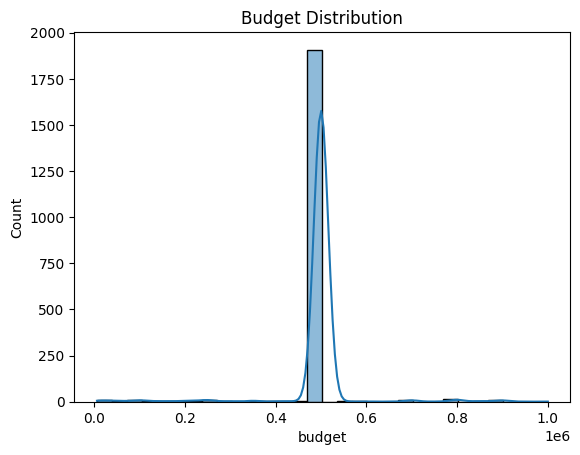

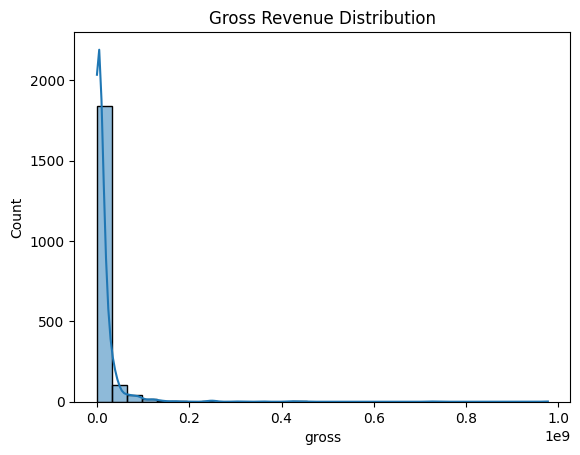

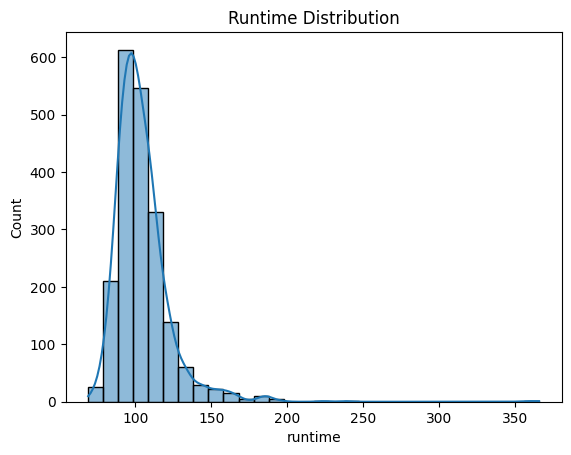

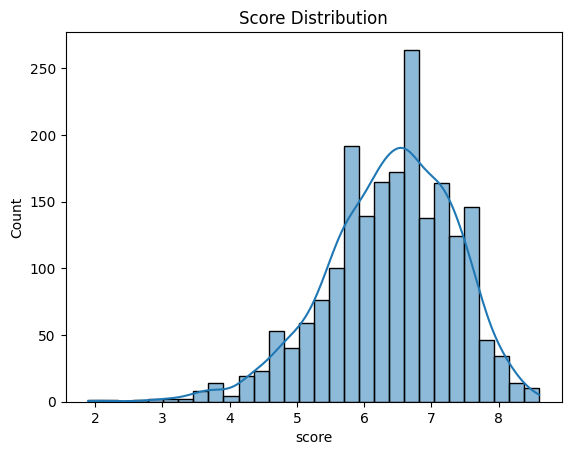

In [ ]:

# Budget Distribution
sns.histplot(df_clean_fil['budget'], bins=30, kde=True)
plt.title("Budget Distribution")
plt.show()

# Gross Distribution
sns.histplot(df_clean_fil['gross'], bins=30, kde=True)
plt.title("Gross Revenue Distribution")
plt.show()

# Runtime Distribution
sns.histplot(df_clean_fil['runtime'], bins=30, kde=True)
plt.title("Runtime Distribution")
plt.show()

# Score Distribution
sns.histplot(df_clean_fil['score'], bins=30, kde=True)
plt.title("Score Distribution")
plt.show()


**The budget distribution indicated to me that our inclusion of the missing-budget movies might skew things too much. So, I'm going to exclude them.**

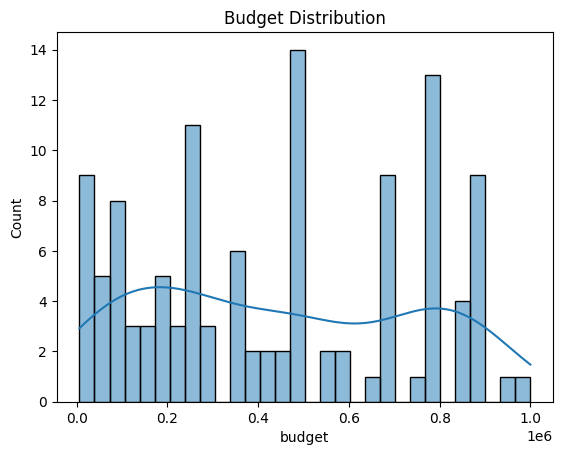

In [ ]:
df_clean_fil = df_clean_fil[df_clean_fil['budget'] != 500005]

# Budget Distribution
sns.histplot(df_clean_fil['budget'], bins=30, kde=True)
plt.title("Budget Distribution")
plt.show()

Check correlations and scatter plots to identify potential predictors:

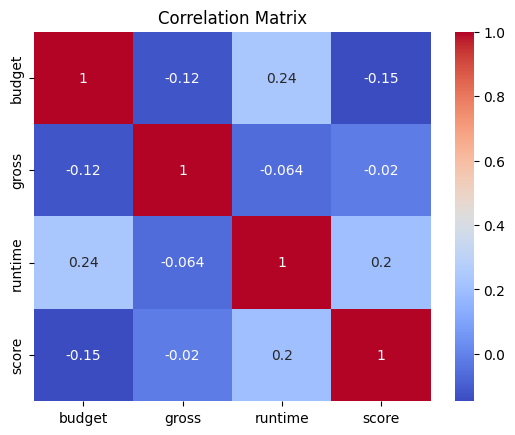

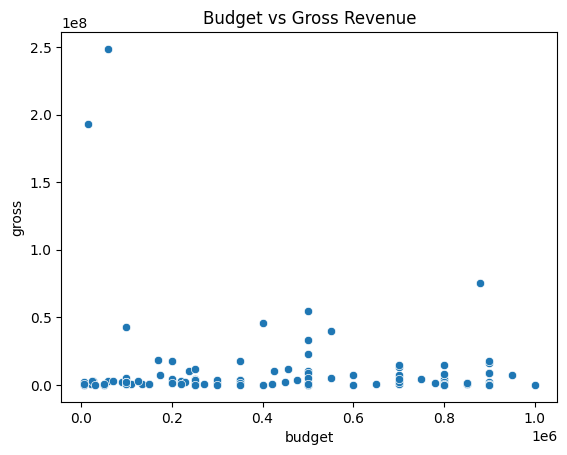

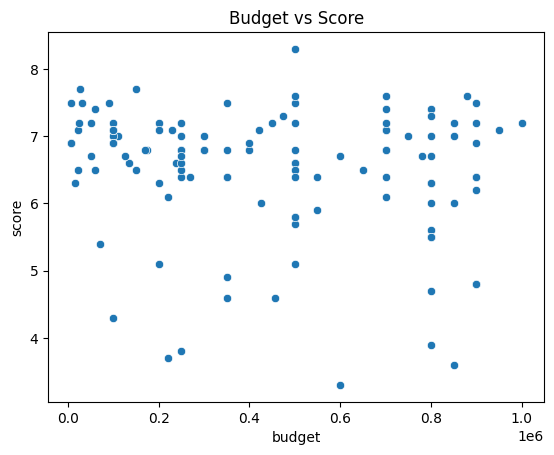

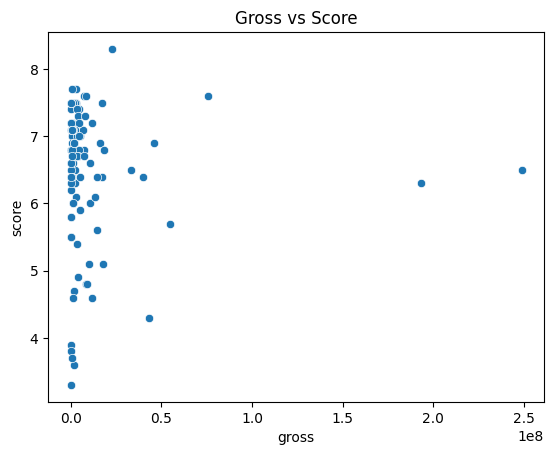

In [ ]:
# Correlation matrix
correlation_matrix = df_clean_fil[['budget', 'gross', 'runtime', 'score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Scatter plot: Budget vs Gross
sns.scatterplot(data=df_clean_fil, x='budget', y='gross')
plt.title("Budget vs Gross Revenue")
plt.show()

# Scatter plot: Budget vs Score
sns.scatterplot(data=df_clean_fil, x='budget', y='score')
plt.title("Budget vs Score")
plt.show()

# Scatter plot: Gross vs Score
sns.scatterplot(data=df_clean_fil, x='gross', y='score')
plt.title("Gross vs Score")
plt.show()


**Impressions from Scatter Plots**

It's hard to see that there are any truly meaningful clusters here. But there may be something that a kNN can pick up on, or that a Random Forest algorithm might be able to differentiate between once we finish encoding the other features we have.

**Frequency Counts**

Visualize the top categories for features like rating, genre, and company:

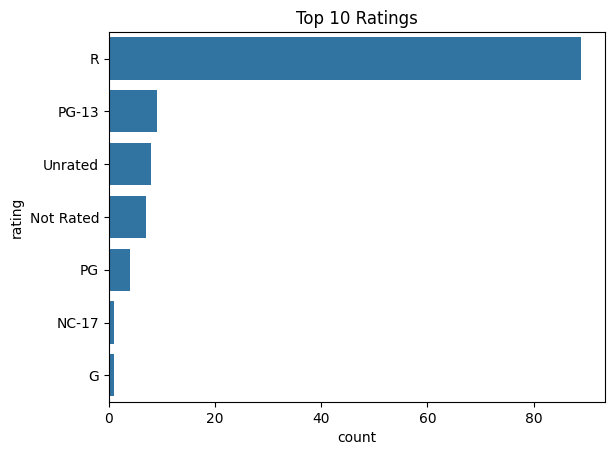

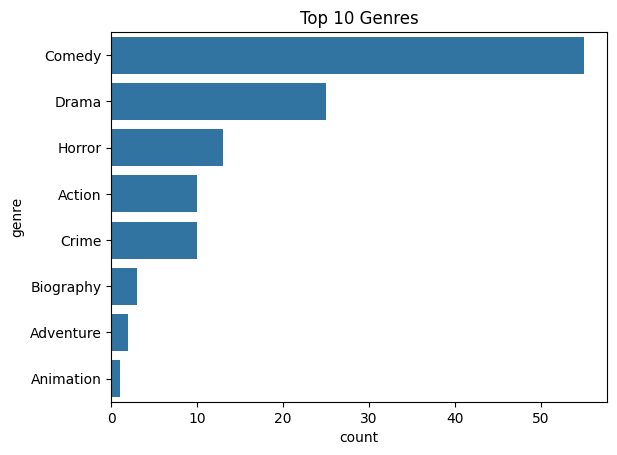

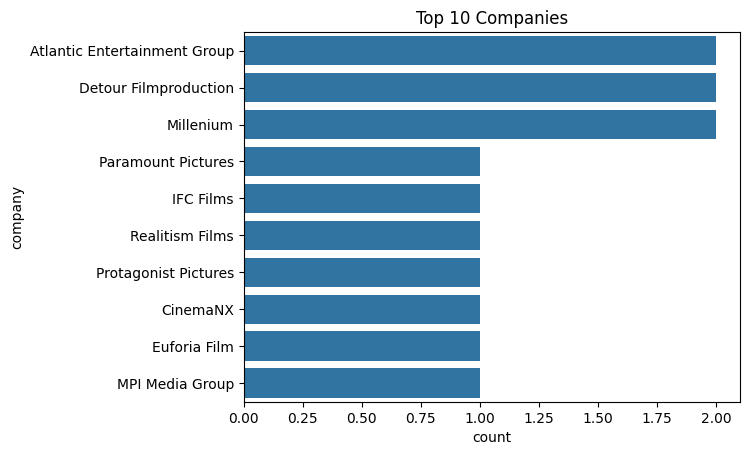

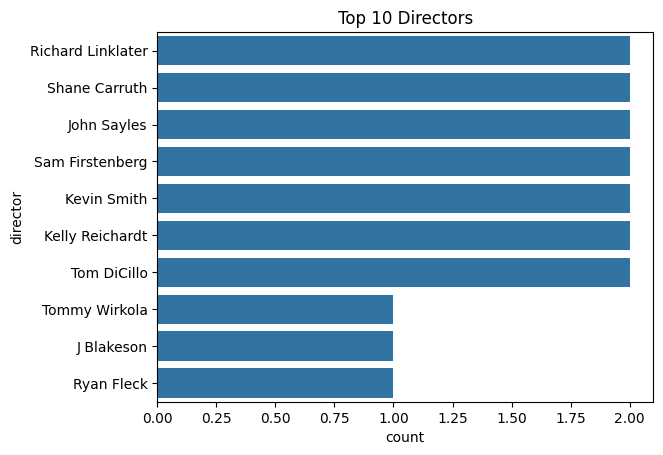

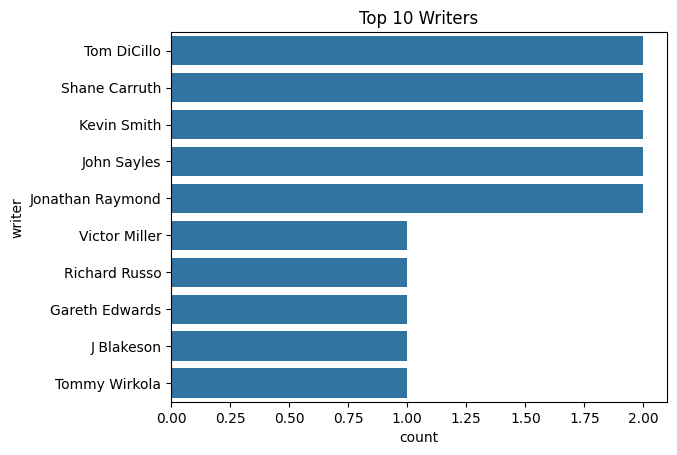

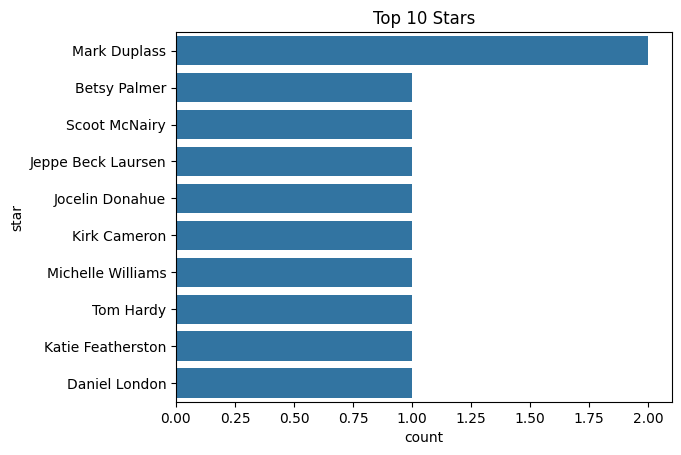

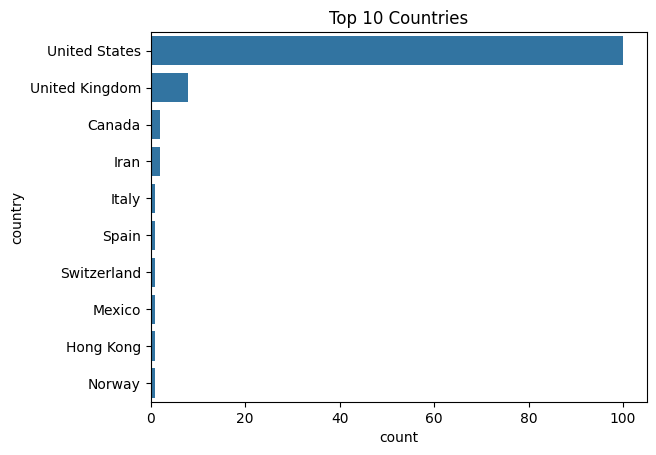

In [ ]:
# Rating
sns.countplot(data=df_clean_fil, y='rating', order=df_clean_fil['rating'].value_counts().index[:10])
plt.title("Top 10 Ratings")
plt.show()

# Genre
sns.countplot(data=df_clean_fil, y='genre', order=df_clean_fil['genre'].value_counts().index[:10])
plt.title("Top 10 Genres")
plt.show()

# Company
sns.countplot(data=df_clean_fil, y='company', order=df_clean_fil['company'].value_counts().index[:10])
plt.title("Top 10 Companies")
plt.show()

# Director
sns.countplot(data=df_clean_fil, y='director', order=df_clean_fil['director'].value_counts().index[:10])
plt.title("Top 10 Directors")
plt.show()

# Writer
sns.countplot(data=df_clean_fil, y='writer', order=df_clean_fil['writer'].value_counts().index[:10])
plt.title("Top 10 Writers")
plt.show()

# Star
sns.countplot(data=df_clean_fil, y='star', order=df_clean_fil['star'].value_counts().index[:10])
plt.title("Top 10 Stars")
plt.show()

# Country
sns.countplot(data=df_clean_fil, y='country', order=df_clean_fil['country'].value_counts().index[:10])
plt.title("Top 10 Countries")
plt.show()

**Impressions from Frequency Distributions**

It looks like we have significanly more movies of genre comedy and movies produced in the US. We'll want to make sure these are scaled when we train the kNN model.

The other features (e.g., writer, director, star, company) each have such low frequency that it seems these might not be useful for prediction. We'll start by including them, but I suspect that they ultimately may not help the models that much if at all.

Final wrangling of date information.

In [ ]:
# Convert 'released' to datetime type
df_clean_fil['released'] = pd.to_datetime(df_clean_fil['released'], errors='coerce')

# Add a month_num columm
month_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Map months to numbers
df_clean_fil['month_num'] = df_clean_fil['month'].map(month_to_number)

# Check the results
print(df_clean_fil[['released','month_num']].head())
print(f"Number of invalid dates (NaT): {df_clean_fil['released'].isna().sum()}")

print(df_clean_fil['released'].dtypes)  # Should print: datetime64[ns]
print(df_clean_fil[['year','month_num']].dtypes)


       released  month_num
43   1980-05-09          5
715  1981-04-15          4
1100 1981-11-11         11
1330 1981-03-27          3
2051 1982-07-28          7
Number of invalid dates (NaT): 0
datetime64[ns]
year         int64
month_num    int64
dtype: object


Simplify and ordinal encode rating values

In [ ]:
# Define the mapping for ratings
rating_mapping = {
    'Not Rated': 'Unrated',
    'X': 'NC-17',
    'TV-PG': 'PG',
    'TV-14': 'PG-13',
    'TV-MA': 'R'
}

# Apply the mapping to simplify ratings
df_clean_fil['rating_simplified'] = df_clean_fil['rating'].replace(rating_mapping)

# Define the order for ordinal encoding
rating_order = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4,
    'NC-17': 5,
    'Unrated': 6
}

# Apply the ordinal encoding
df_clean_fil['rating_encoded'] = df_clean_fil['rating_simplified'].map(rating_order)


print(df_clean_fil[['rating', 'rating_simplified', 'rating_encoded']].head(25))


        rating rating_simplified  rating_encoded
43           R                 R               4
715      NC-17             NC-17               5
1100         R                 R               4
1330         R                 R               4
2051         R                 R               4
2212         R                 R               4
2254        PG                PG               2
2816         R                 R               4
3047         R                 R               4
3122         R                 R               4
3342         R                 R               4
3547         R                 R               4
3582         R                 R               4
3934         R                 R               4
4111     PG-13             PG-13               3
4176         R                 R               4
4635         R                 R               4
4708         R                 R               4
4982        PG                PG               2
5451   Unrated      

For genre encoding, I'm using frequency encoding to reduce dimensionality and because a couple genres appeared more frequently in this low-budget context.



In [ ]:
# Frequency encoding for 'genre'
genre_freq = df_clean_fil['genre'].value_counts()
df_clean_fil['genre_encoded'] = df_clean_fil['genre'].map(genre_freq)


Also using frequency encoding for writer, director, star, and company features, for dimensionality concerns. Knowing full well that this may bias the model potentially towards names with more credits.

In [ ]:
for col in ['director', 'writer', 'star', 'company', 'country']:
    freq = df_clean_fil[col].value_counts()
    df_clean_fil[f'{col}_freq'] = df_clean_fil[col].map(freq)

df_clean_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 43 to 63133
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   titleId            119 non-null    object        
 1   title              119 non-null    object        
 2   rating             119 non-null    object        
 3   genre              119 non-null    object        
 4   released           119 non-null    datetime64[ns]
 5   year               119 non-null    int64         
 6   month              119 non-null    object        
 7   score              119 non-null    float64       
 8   director           119 non-null    object        
 9   writer             119 non-null    object        
 10  star               119 non-null    object        
 11  country            119 non-null    object        
 12  budget             119 non-null    float64       
 13  gross              119 non-null    float64       
 14  company     

In [ ]:
df_clean_fil['titleId'].nunique()

119

Dropping non-encoded features.

In [ ]:
df_encoded = df_clean_fil.select_dtypes(exclude=['object'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 43 to 63133
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   released        119 non-null    datetime64[ns]
 1   year            119 non-null    int64         
 2   score           119 non-null    float64       
 3   budget          119 non-null    float64       
 4   gross           119 non-null    float64       
 5   runtime         119 non-null    float64       
 6   month_num       119 non-null    int64         
 7   rating_encoded  119 non-null    int64         
 8   genre_encoded   119 non-null    int64         
 9   director_freq   119 non-null    int64         
 10  writer_freq     119 non-null    int64         
 11  star_freq       119 non-null    int64         
 12  company_freq    119 non-null    int64         
 13  country_freq    119 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 13.

**Correlation Matrix**

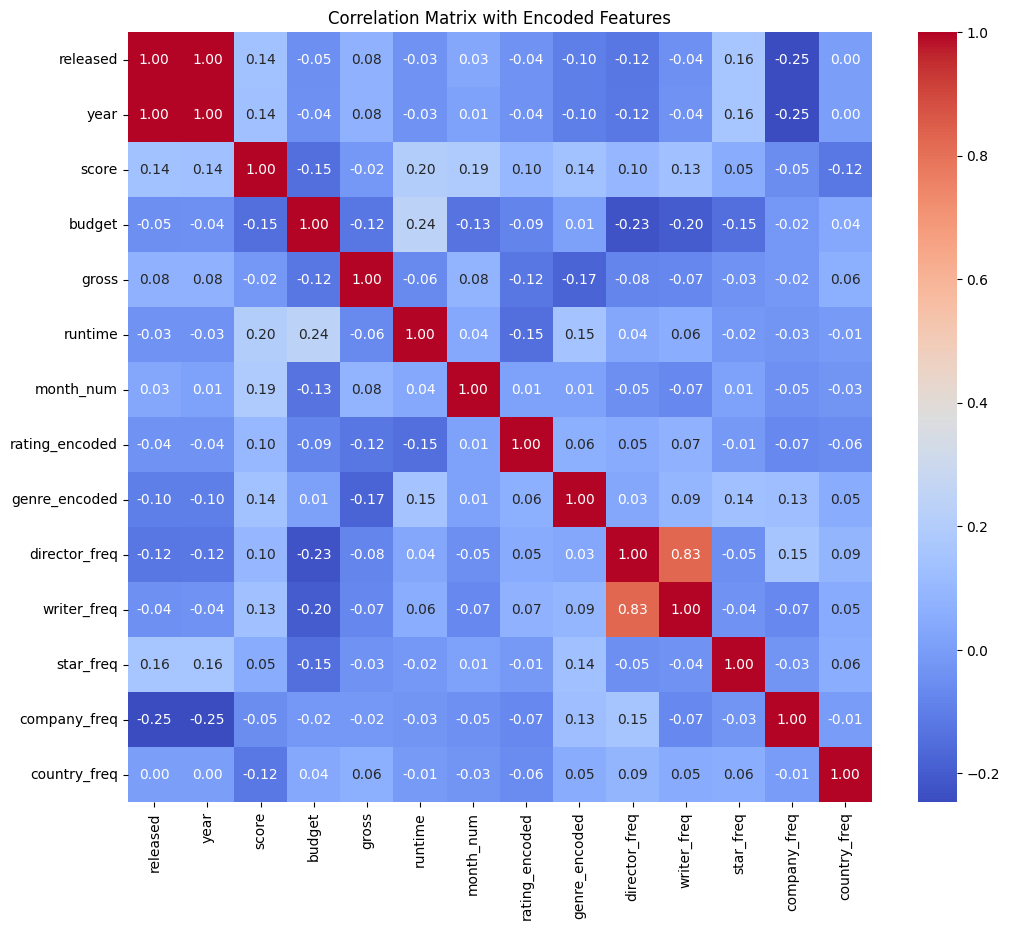

In [ ]:
# Calculate correlation matrix
correlation_matrix = df_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix with Encoded Features")
plt.show()


In [ ]:
# Dropping `released` since it essentially duplicates `year`
df_encoded = df_encoded.drop(columns=['released'])

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 43 to 63133
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            119 non-null    int64  
 1   score           119 non-null    float64
 2   budget          119 non-null    float64
 3   gross           119 non-null    float64
 4   runtime         119 non-null    float64
 5   month_num       119 non-null    int64  
 6   rating_encoded  119 non-null    int64  
 7   genre_encoded   119 non-null    int64  
 8   director_freq   119 non-null    int64  
 9   writer_freq     119 non-null    int64  
 10  star_freq       119 non-null    int64  
 11  company_freq    119 non-null    int64  
 12  country_freq    119 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 13.0 KB


Ready to do the Train-Test splits!

Define Features (X) and Targets (y):
*  For profitability: (gross - budget) / budget
*  For quality: score

In [ ]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df_encoded.drop(columns=['gross','score'])
y_profitability = (df_encoded['gross'] - df_encoded['budget']) / df_encoded['budget']
y_quality = df_encoded['score']

# Split data for profitability
X_train_profit, X_test_profit, y_train_profit, y_test_profit = train_test_split(
    X, y_profitability, test_size=0.2, random_state=42
)

# Split data for quality
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(
    X, y_quality, test_size=0.2, random_state=42
)


**kNN Algorithm**

It's sensitive to feature scaling, so we'll need to standardize.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Scale the features
scaler = StandardScaler()
X_train_profit_scaled = scaler.fit_transform(X_train_profit)
X_test_profit_scaled = scaler.transform(X_test_profit)

X_train_quality_scaled = scaler.fit_transform(X_train_quality)
X_test_quality_scaled = scaler.transform(X_test_quality)

# Train kNN for profitability
knn_profit = KNeighborsRegressor(n_neighbors=5)
knn_profit.fit(X_train_profit_scaled, y_train_profit)
y_pred_profit_knn = knn_profit.predict(X_test_profit_scaled)
mse_profit_knn = mean_squared_error(y_test_profit, y_pred_profit_knn)
r2_profit_knn = r2_score(y_test_profit, y_pred_profit_knn)
print(f"Profitability kNN MSE: {mse_profit_knn}")
print(f"Profitability R² (kNN): {r2_profit_knn}")

# Train kNN for quality
knn_quality = KNeighborsRegressor(n_neighbors=5)
knn_quality.fit(X_train_quality_scaled, y_train_quality)
y_pred_quality_knn = knn_quality.predict(X_test_quality_scaled)
mse_quality_knn = mean_squared_error(y_test_quality, y_pred_quality_knn)
r2_quality_knn = r2_score(y_test_quality, y_pred_quality_knn)
print(f"Quality kNN MSE: {mse_quality_knn}")
print(f"Quality R² (kNN): {r2_quality_knn}")

Profitability kNN MSE: 845275.9674107997
Profitability R² (kNN): -0.24426197334945798
Quality kNN MSE: 1.3019999999999998
Quality R² (kNN): -0.38513196535101457


**Random Forest Algorithm**

Even though Random Forest can handle categorical and numerical data, I'm using the same training-testing data to compare the two algorithms.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest for profitability
rf_profit = RandomForestRegressor(n_estimators=100, random_state=42)
rf_profit.fit(X_train_profit, y_train_profit)
y_pred_profit_rf = rf_profit.predict(X_test_profit)
mse_profit_rf = mean_squared_error(y_test_profit, y_pred_profit_rf)
r2_profit_rf = r2_score(y_test_profit, y_pred_profit_rf)
print(f"Profitability Random Forest MSE: {mse_profit_rf}")
print(f"Profitability R² (Random Forest): {r2_profit_rf}")

# Train Random Forest for quality
rf_quality = RandomForestRegressor(n_estimators=100, random_state=42)
rf_quality.fit(X_train_quality, y_train_quality)
y_pred_quality_rf = rf_quality.predict(X_test_quality)
mse_quality_rf = mean_squared_error(y_test_quality, y_pred_quality_rf)
r2_quality_rf = r2_score(y_test_quality, y_pred_quality_rf)
print(f"Quality Random Forest MSE: {mse_quality_rf}")
print(f"Quality R² (Random Forest): {r2_quality_rf}")


Profitability Random Forest MSE: 896640.3957931623
Profitability R² (Random Forest): -0.3198713689587678
Quality Random Forest MSE: 0.9598385833333344
Quality R² (Random Forest): -0.021123735293575363


The **Mean Squared Error** value lets us know how far the predictions of the model were from the actual values. And **R-squared** gives us a percentage to indicate how well the model is explaining the target variable variance.

# Initial Conclusions

Unfortunately, what we see is that both models are struggling to find meaningful patterns in our (what became through cleaning) very limited data set.

They're both predicting worse than the mean for both profitablilty and quality metrics, though **Random Forest came closest** for quality predictions.

We could consider some alterative metrics to see if that can give us any clearer interpretability.


**Mean Average Error**

We'll see if this helps in interpretation at all, since it is less sensitive to large errors

In [ ]:
from sklearn.metrics import mean_absolute_error

# For profitability
mae_profit_knn = mean_absolute_error(y_test_profit, y_pred_profit_knn)
mae_profit_rf = mean_absolute_error(y_test_profit, y_pred_profit_rf)
print(f"Profitability MAE (kNN): {mae_profit_knn}")
print(f"Profitability MAE (Random Forest): {mae_profit_rf}")

# For quality
mae_quality_knn = mean_absolute_error(y_test_quality, y_pred_quality_knn)
mae_quality_rf = mean_absolute_error(y_test_quality, y_pred_quality_rf)
print(f"Quality MAE (kNN): {mae_quality_knn}")
print(f"Quality MAE (Random Forest): {mae_quality_rf}")


Profitability MAE (kNN): 392.56502317831223
Profitability MAE (Random Forest): 293.32046075404077
Quality MAE (kNN): 0.8249999999999998
Quality MAE (Random Forest): 0.6971666666666678


**Explained Variance Score**

In [ ]:
from sklearn.metrics import explained_variance_score

# For profitability
evs_profit_knn = explained_variance_score(y_test_profit, y_pred_profit_knn)
evs_profit_rf = explained_variance_score(y_test_profit, y_pred_profit_rf)
print(f"Profitability Explained Variance Score (kNN): {evs_profit_knn}")
print(f"Profitability Explained Variance Score (Random Forest): {evs_profit_rf}")

# For quality
evs_quality_knn = explained_variance_score(y_test_quality, y_pred_quality_knn)
evs_quality_rf = explained_variance_score(y_test_quality, y_pred_quality_rf)
print(f"Quality Explained Variance Score (kNN): {evs_quality_knn}")
print(f"Quality Explained Variance Score (Random Forest): {evs_quality_rf}")


Profitability Explained Variance Score (kNN): -0.16844369769954004
Profitability Explained Variance Score (Random Forest): -0.30450772618993716
Quality Explained Variance Score (kNN): -0.365743309384408
Quality Explained Variance Score (Random Forest): -0.0039649077443075775


# Final Initial Reflections and Refinement

Both **MAE** and **Explained Variance** reinforce our interpretation using MSE and R-squared: these models as is are really struggling to make meaningful predictions from this data set.

It's likely that there are features we included that do not help at all to predict the profitability and quality of a movie. And it's also very likely that there are features we didn't have access to in our data set that could be more determinative, such as **marketing budget**, **campaign reach**, and **channel distribution**.

We may have also had scaling issues, which could have affected kNN's distance-based preictions. And there could be skewing in the profitability and quality scores, challenging the models' abilities to generalize.

Next, we'll do some refinements of these models, though, given the metrics we saw, I don't expect a significant increase in predictive power for this data.

**Revisit Frequency Encoded Features**

As we saw in our frequency distribution vizzes, we had only a few writers, directors, stars and companies that had more than one movie in our set. So, I'd like to rerun the train-test without those features and append one-hot encoding for the `genre` dimension.

In [ ]:
# Slimmed down dataframe
df_encoded_slim = df_encoded.drop(columns=['director_freq', 'writer_freq', 'star_freq', 'company_freq', 'country_freq'])

# One-hot encode 'genre'
genre_one_hot = pd.get_dummies(df_clean_fil['genre'], prefix='genre')

# Append one-hot encoded 'genre' to df_encoded
df_encoded_slim = pd.concat([df_encoded_slim, genre_one_hot], axis=1)

print(f"New columns in df_encoded_slim: {df_encoded_slim.columns}")

New columns in df_encoded: Index(['year', 'score', 'budget', 'gross', 'runtime', 'month_num',
       'rating_encoded', 'genre_encoded', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Biography', 'genre_Comedy', 'genre_Crime',
       'genre_Drama', 'genre_Horror'],
      dtype='object')


In [ ]:
df_encoded_slim = df_encoded_slim.drop(columns=['genre_encoded'])
df_encoded_slim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 43 to 63133
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             119 non-null    int64  
 1   score            119 non-null    float64
 2   budget           119 non-null    float64
 3   gross            119 non-null    float64
 4   runtime          119 non-null    float64
 5   month_num        119 non-null    int64  
 6   rating_encoded   119 non-null    int64  
 7   genre_Action     119 non-null    bool   
 8   genre_Adventure  119 non-null    bool   
 9   genre_Animation  119 non-null    bool   
 10  genre_Biography  119 non-null    bool   
 11  genre_Comedy     119 non-null    bool   
 12  genre_Crime      119 non-null    bool   
 13  genre_Drama      119 non-null    bool   
 14  genre_Horror     119 non-null    bool   
dtypes: bool(8), float64(4), int64(3)
memory usage: 8.4 KB


In [ ]:
# Get boolean columns and conver to numeric
bool_columns = df_encoded_slim.select_dtypes(include=['bool']).columns
df_encoded_slim[bool_columns] = df_encoded_slim[bool_columns].astype(int)

print(df_encoded_slim.dtypes)

year                 int64
score              float64
budget             float64
gross              float64
runtime            float64
month_num            int64
rating_encoded       int64
genre_Action         int64
genre_Adventure      int64
genre_Animation      int64
genre_Biography      int64
genre_Comedy         int64
genre_Crime          int64
genre_Drama          int64
genre_Horror         int64
dtype: object


Now, let's retrain and test and see if there are any improvements.

In [ ]:

# Define X and y
X = df_encoded_slim.drop(columns=['gross','score'])
y_profitability = (df_encoded_slim['gross'] - df_encoded_slim['budget']) / df_encoded_slim['budget']
y_quality = df_encoded_slim['score']

# Split data for profitability
X_train_profit, X_test_profit, y_train_profit, y_test_profit = train_test_split(
    X, y_profitability, test_size=0.2, random_state=42
)

# Split data for quality
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(
    X, y_quality, test_size=0.2, random_state=42
)

**kNN Retrain-Retest**

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_profit_scaled = scaler.fit_transform(X_train_profit)
X_test_profit_scaled = scaler.transform(X_test_profit)

X_train_quality_scaled = scaler.fit_transform(X_train_quality)
X_test_quality_scaled = scaler.transform(X_test_quality)

# Train kNN for profitability
knn_profit = KNeighborsRegressor(n_neighbors=5)
knn_profit.fit(X_train_profit_scaled, y_train_profit)
y_pred_profit_knn = knn_profit.predict(X_test_profit_scaled)
mse_profit_knn = mean_squared_error(y_test_profit, y_pred_profit_knn)
r2_profit_knn = r2_score(y_test_profit, y_pred_profit_knn)
print(f"Profitability kNN MSE: {mse_profit_knn}")
print(f"Profitability R² (kNN): {r2_profit_knn}")

# Train kNN for quality
knn_quality = KNeighborsRegressor(n_neighbors=5)
knn_quality.fit(X_train_quality_scaled, y_train_quality)
y_pred_quality_knn = knn_quality.predict(X_test_quality_scaled)
mse_quality_knn = mean_squared_error(y_test_quality, y_pred_quality_knn)
r2_quality_knn = r2_score(y_test_quality, y_pred_quality_knn)
print(f"Quality kNN MSE: {mse_quality_knn}")
print(f"Quality R² (kNN): {r2_quality_knn}")

Profitability kNN MSE: 299087.2759670082
Profitability R² (kNN): 0.5597379571332779
Quality kNN MSE: 1.0452499999999996
Quality R² (kNN): -0.1119886227213116


**Random Forest Retrain-Retest**

In [ ]:
# Train Random Forest for profitability
rf_profit = RandomForestRegressor(n_estimators=100, random_state=42)
rf_profit.fit(X_train_profit, y_train_profit)
y_pred_profit_rf = rf_profit.predict(X_test_profit)
mse_profit_rf = mean_squared_error(y_test_profit, y_pred_profit_rf)
r2_profit_rf = r2_score(y_test_profit, y_pred_profit_rf)
print(f"Profitability Random Forest MSE: {mse_profit_rf}")
print(f"Profitability R² (Random Forest): {r2_profit_rf}")

# Train Random Forest for quality
rf_quality = RandomForestRegressor(n_estimators=100, random_state=42)
rf_quality.fit(X_train_quality, y_train_quality)
y_pred_quality_rf = rf_quality.predict(X_test_quality)
mse_quality_rf = mean_squared_error(y_test_quality, y_pred_quality_rf)
r2_quality_rf = r2_score(y_test_quality, y_pred_quality_rf)
print(f"Quality Random Forest MSE: {mse_quality_rf}")
print(f"Quality R² (Random Forest): {r2_quality_rf}")

Profitability Random Forest MSE: 897502.6391922488
Profitability R² (Random Forest): -0.3211406073076839
Quality Random Forest MSE: 0.9149832916666673
Quality R² (Random Forest): 0.026595541436565617


A significant improvement for our kNN profitability metrics and a slight improvement in our Random Forest quality metrics. But neither are great, still, indicating that these are not the features we're looking for, to paraphrase Obi-wan Kenobi.

Next, we might want to look for different `k` values for the kNN algorithm, and we might want to adjust our Random Forest hyperparameters and check for feature importance.

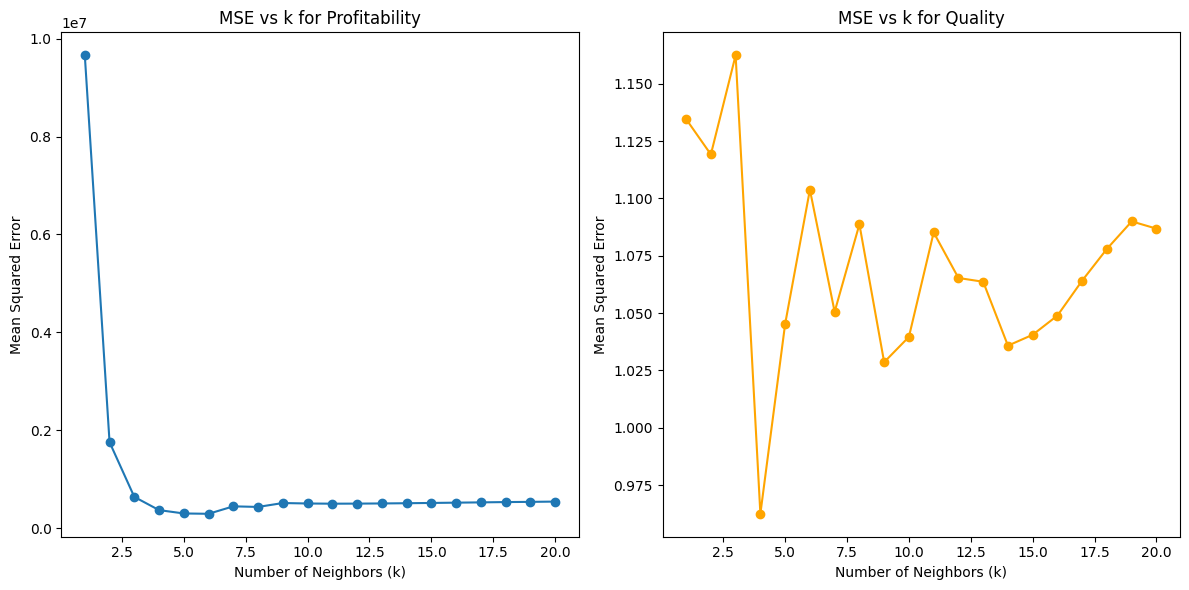

In [ ]:
# Define a range of k values to test
k_values = range(1, 21)  # Test k from 1 to 20
mse_results_profit = []
mse_results_quality = []

# Iterate over k values
for k in k_values:
    # Initialize kNN for profitability
    knn_profit = KNeighborsRegressor(n_neighbors=k)
    knn_profit.fit(X_train_profit_scaled, y_train_profit)
    y_pred_profit = knn_profit.predict(X_test_profit_scaled)
    mse_results_profit.append(mean_squared_error(y_test_profit, y_pred_profit))

    # Initialize kNN for quality
    knn_quality = KNeighborsRegressor(n_neighbors=k)
    knn_quality.fit(X_train_quality_scaled, y_train_quality)
    y_pred_quality = knn_quality.predict(X_test_quality_scaled)
    mse_results_quality.append(mean_squared_error(y_test_quality, y_pred_quality))

# Plot the results
plt.figure(figsize=(12, 6))

# Plot for profitability
plt.subplot(1, 2, 1)
plt.plot(k_values, mse_results_profit, marker='o')
plt.title('MSE vs k for Profitability')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')

# Plot for quality
plt.subplot(1, 2, 2)
plt.plot(k_values, mse_results_quality, marker='o', color='orange')
plt.title('MSE vs k for Quality')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()


We're looking for the `k` value will yield the lowest MSE. When predicting Profitability, it looks like 5 is best. And when predicting for Quality, it looks incredibly unstable but that 9 is good to try. (But we could be in danger of overfitting.)

In [ ]:
# Train kNN for profitability
knn_profit = KNeighborsRegressor(n_neighbors=5)
knn_profit.fit(X_train_profit_scaled, y_train_profit)
y_pred_profit_knn = knn_profit.predict(X_test_profit_scaled)
mse_profit_knn = mean_squared_error(y_test_profit, y_pred_profit_knn)
r2_profit_knn = r2_score(y_test_profit, y_pred_profit_knn)
print(f"Profitability kNN MSE: {mse_profit_knn}")
print(f"Profitability R² (kNN): {r2_profit_knn}")

# Train kNN for quality
knn_quality = KNeighborsRegressor(n_neighbors=9)
knn_quality.fit(X_train_quality_scaled, y_train_quality)
y_pred_quality_knn = knn_quality.predict(X_test_quality_scaled)
mse_quality_knn = mean_squared_error(y_test_quality, y_pred_quality_knn)
r2_quality_knn = r2_score(y_test_quality, y_pred_quality_knn)
print(f"Quality kNN MSE: {mse_quality_knn}")
print(f"Quality R² (kNN): {r2_quality_knn}")

Profitability kNN MSE: 299087.2759670082
Profitability R² (kNN): 0.5597379571332779
Quality kNN MSE: 1.0286059670781897
Quality R² (kNN): -0.09428187768878193


This adjusting of `n_neighbors` did improve our R-squared for Profitability, but our MSE is still very large. Unfortunately, our R-squared for Quality is still negative, which means the model is still on the struggle bus.

Let's take a quick look at **feature importance** with the Random Forest model.

In [ ]:
# Get feature importances from Random Forest for quality
importance_rf_quality = rf_quality.feature_importances_
sorted_features = sorted(zip(X.columns, importance_rf_quality), key=lambda x: x[1], reverse=True)

# Display the top features
print("Top features for quality prediction:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Get feature importances from Random Forest for profitability
importance_rf_profit = rf_profit.feature_importances_
sorted_features_profit = sorted(zip(X.columns, importance_rf_profit), key=lambda x: x[1], reverse=True)

print("\nTop features for profitability prediction:")
for feature, importance in sorted_features_profit:
    print(f"{feature}: {importance:.4f}")


Top features for quality prediction:
year: 0.2809
runtime: 0.2671
budget: 0.1449
month_num: 0.1216
genre_Horror: 0.0652
genre_Action: 0.0450
rating_encoded: 0.0279
genre_Drama: 0.0152
genre_Adventure: 0.0122
genre_Comedy: 0.0102
genre_Crime: 0.0071
genre_Biography: 0.0027
genre_Animation: 0.0000

Top features for profitability prediction:
budget: 0.4457
runtime: 0.1813
year: 0.1087
genre_Horror: 0.0813
rating_encoded: 0.0674
genre_Adventure: 0.0419
month_num: 0.0344
genre_Drama: 0.0150
genre_Crime: 0.0142
genre_Comedy: 0.0071
genre_Action: 0.0019
genre_Biography: 0.0010
genre_Animation: 0.0000


I'm surprised to see how year and runtime are determined to be the most important features for Random Forest to determine quality, but not particularly surprised that the budget feature helps determine profitability.




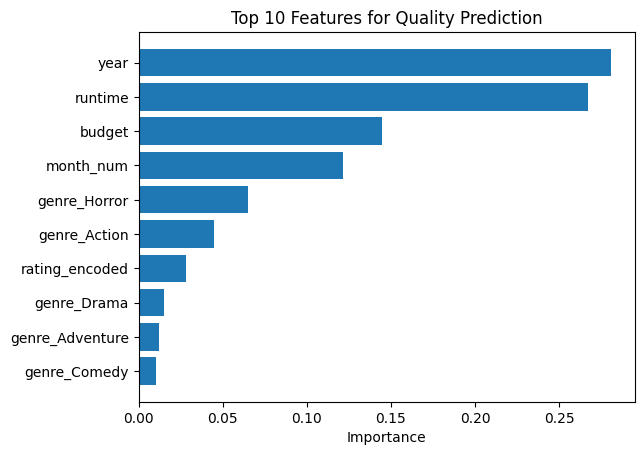

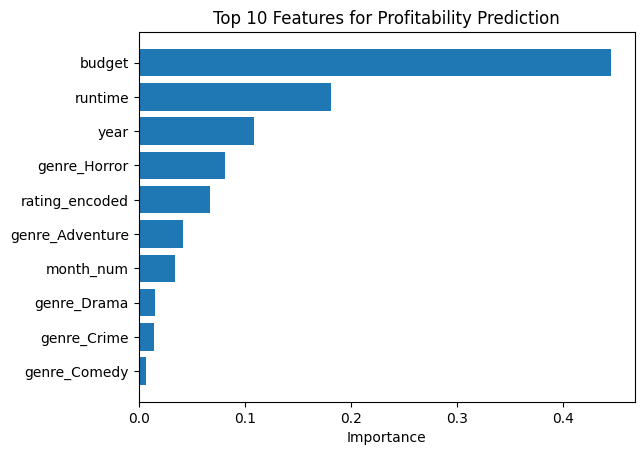

In [ ]:
# Visualize quality feature importance
quality_features, quality_importances = zip(*sorted_features[:10])  # Top 10 features
plt.barh(quality_features, quality_importances)
plt.xlabel("Importance")
plt.title("Top 10 Features for Quality Prediction")
plt.gca().invert_yaxis()
plt.show()

# Visualize profitability feature importance
profit_features, profit_importances = zip(*sorted_features_profit[:10])
plt.barh(profit_features, profit_importances)
plt.xlabel("Importance")
plt.title("Top 10 Features for Profitability Prediction")
plt.gca().invert_yaxis()
plt.show()


**Log Transformation and Target Standardization**

In [ ]:

# Apply log transformation to profitability
y_train_profit_log = np.log1p(y_train_profit)  # log1p handles log(0) cases
y_test_profit_log = np.log1p(y_test_profit)

# Verify transformation
print("Profitability target (transformed):")
print(f"Min: {y_train_profit_log.min()}, Max: {y_train_profit_log.max()}")

# Standardize the quality target
scaler_quality = StandardScaler()
y_train_quality_scaled = scaler_quality.fit_transform(y_train_quality.values.reshape(-1, 1)).flatten()
y_test_quality_scaled = scaler_quality.transform(y_test_quality.values.reshape(-1, 1)).flatten()

# Verify scaling
print(f"Mean (quality target): {y_train_quality_scaled.mean()}, Std: {y_train_quality_scaled.std()}")


Profitability target (transformed):
Min: -5.864831896174599, Max: 9.464237092897335
Mean (quality target): -1.6489733555222062e-15, Std: 1.0


**Using GridSearchCV for Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [None, 10, 20, 30],     # Maximum tree depth
    'min_samples_split': [2, 5, 10]      # Minimum samples required to split a node
}

# Grid search for profitability
rf_grid_profit = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, scoring='neg_mean_squared_error', cv=5)
rf_grid_profit.fit(X_train_profit, y_train_profit_log)
print(f"Best params for profitability: {rf_grid_profit.best_params_}")

# Grid search for quality
rf_grid_quality = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, scoring='neg_mean_squared_error', cv=5)
rf_grid_quality.fit(X_train_quality, y_train_quality)
print(f"Best params for quality: {rf_grid_quality.best_params_}")


Best params for profitability: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best params for quality: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Define hyperparameter grid
knn_param_grid = {'n_neighbors': range(1, 21)}

# Grid search for profitability
knn_grid_profit = GridSearchCV(KNeighborsRegressor(), knn_param_grid, scoring='neg_mean_squared_error', cv=5)
knn_grid_profit.fit(X_train_profit_scaled, y_train_profit_log)
print(f"Best k for profitability: {knn_grid_profit.best_params_}")

# Grid search for quality
knn_grid_quality = GridSearchCV(KNeighborsRegressor(), knn_param_grid, scoring='neg_mean_squared_error', cv=5)
knn_grid_quality.fit(X_train_quality_scaled, y_train_quality_scaled)
print(f"Best k for quality: {knn_grid_quality.best_params_}")


Best k for profitability: {'n_neighbors': 11}
Best k for quality: {'n_neighbors': 10}


**Tuned Model Evaluation - Random Forest**

In [ ]:
# Example: Retrain Random Forest with best params for profitability
rf_best_profit = RandomForestRegressor(**rf_grid_profit.best_params_, random_state=42)
rf_best_profit.fit(X_train_profit, y_train_profit_log)
y_pred_profit_log = rf_best_profit.predict(X_test_profit)

# Transform predictions back to original scale
y_pred_profit = np.expm1(y_pred_profit_log)  # Reverse log1p transformation

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
mse_profit = mean_squared_error(y_test_profit, y_pred_profit)
r2_profit = r2_score(y_test_profit, y_pred_profit)
print(f"Tuned Random Forest Profitability - MSE: {mse_profit}, R^2: {r2_profit}")

# Retrain Random Forest with best params for quality
rf_best_quality = RandomForestRegressor(**rf_grid_quality.best_params_, random_state=42)
rf_best_quality.fit(X_train_quality, y_train_quality)

# Predict on the test set
y_pred_quality = rf_best_quality.predict(X_test_quality)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_quality = mean_squared_error(y_test_quality, y_pred_quality)
mae_quality = mean_absolute_error(y_test_quality, y_pred_quality)
r2_quality = r2_score(y_test_quality, y_pred_quality)

print(f"Tuned Random Forest Quality - MSE: {mse_quality}")
print(f"Tuned Random Forest Quality - MAE: {mae_quality}")
print(f"Tuned Random Forest Quality - R^2: {r2_quality}")



Tuned Random Forest Profitability - MSE: 713497.3821820765, R^2: -0.050281440572517155
Tuned Random Forest Quality - MSE: 0.9210972662722913
Tuned Random Forest Quality - MAE: 0.6781987362085364
Tuned Random Forest Quality - R^2: 0.020091193002161556


# Key Takeaways
**Profitability Prediction:**

kNN outperformed Random Forest but still struggles with high error, suggesting profitability might require additional or more directly relevant features (e.g., marketing budget, release region).


**Quality Prediction:**

Random Forest remains the stronger choice for predicting quality, likely due to its ability to model feature interactions effectively.

**The biggest takeaway** for me is that my dataset was flawed. I decided to do what I could to fix it for this project, but that required many assumptions and ultimately slashed the amount of data I actually had to work with.

Additionally, features that I was hoping would be determinative for prediction (star, director, writer, production company) didn't have enough movies associated with them to be able to establish patterns on their own. If I were able to meaningfully encode, say, the average scores of their other projects or grosses of their other projects, that may have helped as an alternative to the simplistic frequency encoding I tried initially.

What I would want to do with more time is get a higher quality data set of movies that also included or could be combined with features like marketing budget, reach, engagement, and distribution, as those could also have a significant influence on predicting financial and critical success. I might also devise a score for both quality and profitability for writer, director, star, and company features which could be more useful, at least for movies involving people with established careers.